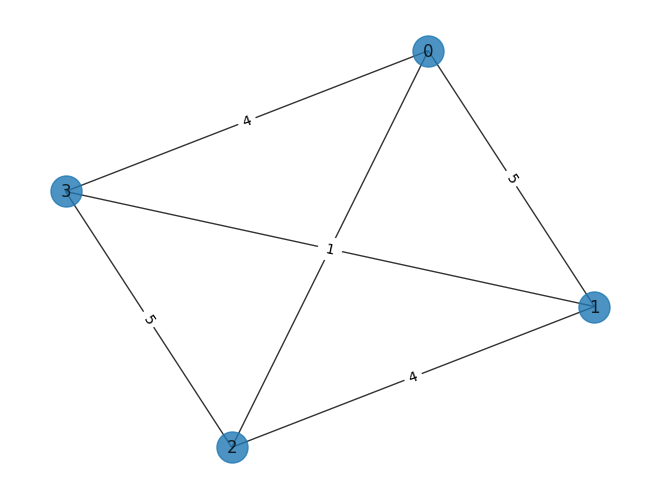

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

graph = nx.Graph()
graph.add_nodes_from([0, 1, 2, 3])
graph.add_edges_from([
    (0, 1, {'weight': 5}),
    (1, 2, {'weight': 4}),
    (2, 0, {'weight': 1}),
    (2, 3, {'weight': 5}),
    (3, 0, {'weight': 4}),
    (3, 1, {'weight': 1})])
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=True, alpha=0.8, node_size=500)
edge_labels = {(u, v): d['weight'] for u, v, d in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)

plt.show()

In [2]:
from qiskit import QuantumCircuit, Aer
from qiskit.circuit import Parameter

def maxcut_obj(solution, graph):
    obj = 0
    for i, j in graph.edges():
        if solution[i] != solution[j]:
            obj -= graph[i][j]['weight']
    return obj

In [3]:
def compute_expectation(counts, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

In [4]:
def create_qaoa_circ(graph, theta):
    nqubits = len(graph.nodes())
    n_layers = len(theta)//2 
    beta = theta[:n_layers]
    gamma = theta[n_layers:]

    qc = QuantumCircuit(nqubits)

    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        for pair in list(graph.edges()):
            qc.rzz(2 * gamma[layer_index] * graph[pair[0]][pair[1]]['weight'], pair[0], pair[1])
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)

    qc.measure_all()
    return qc

In [5]:
def get_expectation(graph, shots=512):
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots

    
    def execute_circ(theta):
        qc = create_qaoa_circ(graph, theta)
        counts = backend.run(qc, seed_simulator=10,
                             nshots=512).result().get_counts()
        return compute_expectation(counts, graph)

    return execute_circ

In [6]:
from scipy.optimize import minimize
expectation = get_expectation(graph)
res = minimize(expectation,
               [2.0, 2.0],
               method='COBYLA')
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -13.74609375
       x: [ 3.472e+00  1.483e+00]
    nfev: 33
   maxcv: 0.0

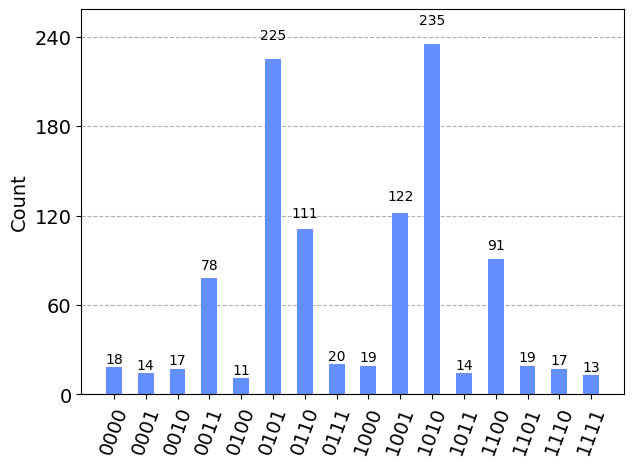

In [7]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512
qc_res = create_qaoa_circ(graph, res.x)
counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts)

In [8]:
print(counts)

{'0000': 18, '1011': 14, '1110': 17, '1111': 13, '1101': 19, '0111': 20, '0001': 14, '0011': 78, '1100': 91, '0100': 11, '0110': 111, '1010': 235, '0010': 17, '0101': 225, '1000': 19, '1001': 122}
